## Classification BERT (AE)

東北大学のBERT-LARGEを使用。文章とAEを入力して、文章のAEかどうかの結果をコサイン類似度で-1~1で返す
- https://qiita.com/Dash400air/items/a616ef8d088e003dfd4c
- https://dev.classmethod.jp/articles/huggingface-jp-text-classification/

## Required Libraries

In [1]:
!pip install transformers jaconv neologdn fugashi ipadic mecab-python3 unidic-lite

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.2 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.3/613.3 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 49.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.5/581.5 kB 8.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 23.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.9 MB/s eta 0:00:00:00:01
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-none-any.whl size=

In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import random
import numpy as np
from numpy.linalg import norm
import warnings
import seaborn as sns
import ast
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report,roc_auc_score,roc_curve,confusion_matrix
import transformers
from transformers import BertJapaneseTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, logging, BertModel
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Notebook Settings

In [3]:
#os.environ['CUDA_VISIBLE_DEVICES']="0"

In [2]:
tqdm.pandas()

In [3]:
warnings.filterwarnings('ignore')
num_of_seed = 0
random.seed(num_of_seed)
np.random.seed(num_of_seed)
torch.manual_seed(num_of_seed)
torch.cuda.manual_seed_all(num_of_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Constant Parameters

In [4]:
DATA = './output/ae_dataset.csv'
TOHOKU_BERT='cl-tohoku/bert-large-japanese'
OUTPUT_PATH = "./output/classificationBertAE"

In [5]:
MAX_LENGTH = 512
EPOCH = 5
BATCH_SIZE = 32

### Input Data

In [7]:
df_data = pd.read_csv(DATA)

## DataSet Creation

In [47]:
df_data.columns = ['row', 'word', 'label']

In [48]:
# ラベルの二値化
df_data['label'] = df_data['label'].apply(lambda x: 0 if x else 1)

In [49]:
# Holdout
df_train_val, df_holdout = train_test_split(df_data, test_size=0.1, stratify=df_data['label'])

In [12]:
# 学習データとテストデータ
# df_train_val = df_train_val.drop_duplicates(['row', 'label']) # ラベルの数を合わせてデータを減らす
df_train, df_val = train_test_split(df_train_val, test_size=0.1, stratify=df_train_val['label'])

In [13]:
df_holdout.value_counts('label')

label
1    4050
0    1047
dtype: int64

In [14]:
df_train.value_counts('label')

label
1    32796
0     8482
dtype: int64

In [15]:
df_val.value_counts('label')

label
1    3644
0     943
dtype: int64

In [107]:
#df_holdout.to_csv(f'{OUTPUT_PATH}/df_holdout.csv', index=False)
#df_train.to_csv(f'{OUTPUT_PATH}/df_train.csv', index=False)
#df_val.to_csv(f'{OUTPUT_PATH}/df_val.csv', index=False)

## Model Engineering
東北大学のBERT-LARGEを使用してBERTのモデルを構築。１つのBERTに対して２つのSentenceをInputする

In [6]:
class ClasificationBertJapanese:
    def __init__(self, model_path, tokenizer_path, batch_size):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.batch_size = batch_size
        self.device = self.init_device()
        self.tokenizer = self.init_tokenizer()
        self.model = self.init_model()
    
    def init_device(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return device

    def init_tokenizer(self):
        tokenizer = BertJapaneseTokenizer.from_pretrained(self.tokenizer_path)
        return tokenizer
    
    def init_model(self):
        model = BertForSequenceClassification.from_pretrained(self.model_path).to(self.device)
        return model
    
    def inference(self, texts, words):
        # トークン化
        row_word_tokens = [(self.tokenizer.tokenize(text), self.tokenizer.tokenize(word)) for text, word in zip(texts, words)]
        preds = []
        for i in range(0, len(row_word_tokens), self.batch_size):
            with torch.no_grad():
                inputs = self.tokenizer.batch_encode_plus(
                    row_word_tokens[i:i+self.batch_size], 
                    return_tensors='pt', 
                    truncation='only_first', 
                    is_split_into_words=False,
                    padding='max_length', 
                    max_length=MAX_LENGTH
                ).to(self.device)
                outputs = self.model(**inputs)
                m = torch.nn.Softmax(dim=1)
                o_args = m(outputs.logits)
                o_args_array = o_args.to('cpu').detach().numpy().copy()
                preds += o_args_array[:,1].tolist()
                torch.cuda.empty_cache()
        return preds

In [16]:
bert = ClasificationBertJapanese(model_path=TOHOKU_BERT, tokenizer_path=TOHOKU_BERT, batch_size=BATCH_SIZE)

Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

## Dataset

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df_encode, labels):
        self.df_encode = df_encode
        self.labels = labels

    def __getitem__(self, idx):
        item = {col: torch.tensor(self.df_encode[col].to_list()[idx]) for col in self.df_encode.columns}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
df_train['row_tokens'] = df_train['row'].apply(lambda x: bert.tokenizer.tokenize(x))
df_train['word_tokens'] = df_train['word'].apply(lambda x: bert.tokenizer.tokenize(x))
df_train['encode'] = df_train.apply(
    lambda x: bert.tokenizer.encode_plus(x['row_tokens'] ,x['word_tokens'], padding='max_length', max_length=MAX_LENGTH, is_pretokenized=True, truncation='only_first',), axis=1)

In [19]:
df_val['row_tokens'] = df_val['row'].apply(lambda x: bert.tokenizer.tokenize(x))
df_val['word_tokens'] = df_val['word'].apply(lambda x: bert.tokenizer.tokenize(x))
df_val['ids'] = df_val.apply(lambda x: bert.tokenizer.encode(x['row_tokens'] ,x['word_tokens'] , is_pretokenized=True), axis=1)
df_val['encode'] = df_val.apply(
    lambda x: bert.tokenizer.encode_plus(x['row_tokens'] ,x['word_tokens'], padding='max_length', max_length=MAX_LENGTH, is_pretokenized=True, truncation='only_first'), axis=1)

In [20]:
train_dataset = Dataset(pd.DataFrame(df_train['encode'].to_list()), df_train['label'].to_list())
val_dataset = Dataset(pd.DataFrame(df_val['encode'].to_list()), df_val['label'].to_list())

## Training

In [21]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    """
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)  
    """
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [26]:
training_args = TrainingArguments(
    output_dir=OUTPUT_PATH,
    overwrite_output_dir = 'True',
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=2e-5,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [27]:
trainer = Trainer(
    model=bert.model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [28]:
trainer.train()
#trainer.save_model()

***** Running training *****
  Num examples = 41278
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6450
  Number of trainable parameters = 337443842


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.211400,0.162408,0.938304,0.938304,0.938304,0.938304
1000,0.151500,0.147522,0.948768,0.948768,0.948768,0.948768
1500,0.127100,0.168941,0.946806,0.946806,0.946806,0.946806
2000,0.107000,0.152479,0.952692,0.952692,0.952692,0.952692
2500,0.107500,0.123011,0.959015,0.959015,0.959015,0.959015
3000,0.072400,0.181541,0.955308,0.955308,0.955308,0.955308
3500,0.070400,0.162399,0.953564,0.953564,0.953564,0.953564
4000,0.059100,0.163845,0.960977,0.960977,0.960977,0.960977
4500,0.036600,0.188376,0.961413,0.961413,0.961413,0.961413
5000,0.046700,0.164673,0.961195,0.961195,0.961195,0.961195


***** Running Evaluation *****
  Num examples = 4587
  Batch size = 32
Saving model checkpoint to ./output/classificationBertAE/checkpoint-500
Configuration saved in ./output/classificationBertAE/checkpoint-500/config.json
Model weights saved in ./output/classificationBertAE/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4587
  Batch size = 32
Saving model checkpoint to ./output/classificationBertAE/checkpoint-1000
Configuration saved in ./output/classificationBertAE/checkpoint-1000/config.json
Model weights saved in ./output/classificationBertAE/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4587
  Batch size = 32
Saving model checkpoint to ./output/classificationBertAE/checkpoint-1500
Configuration saved in ./output/classificationBertAE/checkpoint-1500/config.json
Model weights saved in ./output/classificationBertAE/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4587
  Batch size =

## Evaluation

In [7]:
bert = ClasificationBertJapanese(model_path="./output/classificationBertAE/checkpoint-5500", tokenizer_path=TOHOKU_BERT, batch_size=BATCH_SIZE)

In [8]:
df_holdout = pd.read_csv(f'{OUTPUT_PATH}/validation_result.csv')
df_holdout['label']=df_holdout['label'].apply(lambda x: 1 if x==0 else 0)

In [9]:
preds=[]
for i in tqdm(range(len(df_holdout))):
    preds+=bert.inference([df_holdout.iloc[i,:]['row']], [df_holdout.iloc[i,:]['word']])
df_holdout['pred']=preds
df_holdout['pred']=df_holdout['pred'].apply(lambda x: 1-x)

100%|██████████| 5097/5097 [08:43<00:00,  9.74it/s]


### Histgram

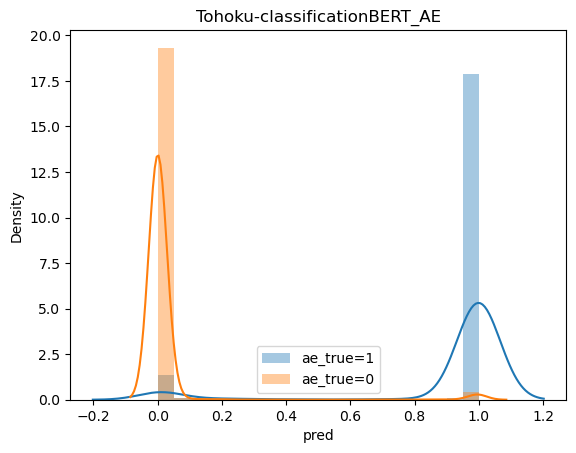

In [11]:
sns.distplot(df_holdout[df_holdout['label']==1]['pred'], bins=20,label="ae_true=1").set(title='Tohoku-classificationBERT_AE')
sns.distplot(df_holdout[df_holdout['label']==0]['pred'], bins=20,label="ae_true=0")
plt.legend()
plt.show()

### ROC-AUC

In [12]:
# AUC
auc = roc_auc_score(df_holdout['label'], df_holdout['pred'])
# # ROC曲線の値の生成：fpr、tpr、閾値
fpr, tpr, thresholds = roc_curve(df_holdout['label'], df_holdout['pred'])

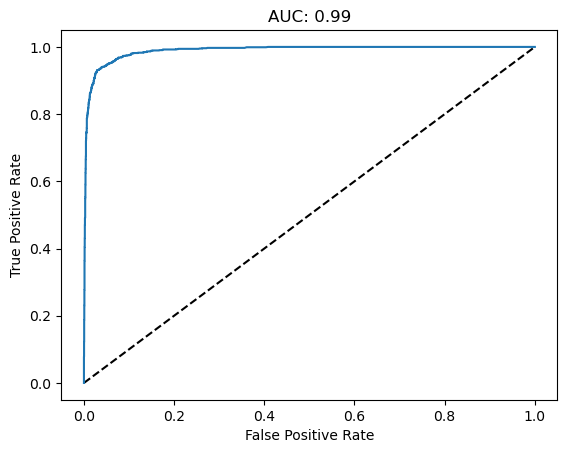

In [13]:
# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'AUC: {round(auc,2)}')
plt.show()

In [14]:
df_holdout['pred_label'] = df_holdout['pred'].apply(lambda x: 1 if x > 0.7 else 0)
tn, fp, fn, tp = confusion_matrix(df_holdout['label'], df_holdout['pred_label']).ravel()
print(f'tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp}')
pd.DataFrame(confusion_matrix(df_holdout['label'], df_holdout['pred_label']))

tn:3955, fp:95, fn:96, tp:951


,0,1
0,3955,95
1,96,951


In [17]:
print(classification_report(df_holdout['label'], df_holdout['pred_label'], target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4050
           1       0.91      0.91      0.91      1047

    accuracy                           0.96      5097
   macro avg       0.94      0.94      0.94      5097
weighted avg       0.96      0.96      0.96      5097



In [15]:
df_holdout

,row,word,label,pred,pred_label
0,G2白血球減少、G2好中球減少は回復。,白血球減少,1,0.999840,1
1,38.5°Cの発熱で予約外にて受診。GRADE3の薬剤性ILD(間質性肺疾患)発現し、入院。,GRADE3の薬剤性ILD(間質性肺疾患)発現し,0,0.000016,0
2,腫瘍増悪の転帰は不明。,腫瘍,0,0.000031,0
3,再診時に下血の症状あり、赤沈上昇あり、UC(潰瘍性大腸炎)悪化と診断、入院。,大腸炎,0,0.000902,0
4,貧血のため、リムパーザ錠200MG×2回/日に減量再開。,リムパーザ,0,0.000013,0
...,...,...,...,...,...
5092,難治性続発性気胸、脳転移、遅発性肺障害(重篤でない)の転帰は不明。,続発性気胸,0,0.000031,0
5093,HB:7.3、G3貧血発現。リムパーザ休薬。,HB:7,0,0.000013,0
5094,リムパーザ錠内服約15ヶ月(再開後3ヶ月)、HB:5.9にてGRADE3の貧血発現、輸血を実施。,輸血を実施,0,0.000015,0
5095,味覚異常(重篤でない)を理由にリムパーザ錠投与中止した。,リムパーザ,0,0.000015,0


## Output

In [16]:
df_holdout[['row','word','label','pred','pred_label']].to_csv(f'{OUTPUT_PATH}/validation_result.csv', index=False)